# IFN703_Sem2_2020 Very Short-term Forecasting Model for Residential PV Power Generation Using Artificial Neural Networks

Pattarachai Roongsritong n10548467 QUT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import necessay libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import glob
from datetime import datetime
from dateutil import tz

In [ ]:
#import the first file containing 20k row for an exploratory analysis
df = pd.read_csv("/content/drive/My Drive/IFN703_advanced_project/2019-01.rows1-20000.csv")
df.tail()

,t_stamp_utc,site_id,energy_(Wh),voltage_max_(V),voltage_min_(V)
19994,2019-01-08 10:10:00+00:00,3011403,-0.3311,236.5,234.5
19995,2019-01-08 10:15:00+00:00,3011403,-0.3286,237.4,235.0
19996,2019-01-08 10:20:00+00:00,3011403,-0.3272,237.6,235.7
19997,2019-01-08 10:25:00+00:00,3011403,-0.3306,238.1,236.0
19998,2019-01-08 10:30:00+00:00,3011403,-0.3294,237.7,235.4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   t_stamp_utc      19999 non-null  object 
 1   site_id          19999 non-null  int64  
 2   energy_(Wh)      19999 non-null  float64
 3   voltage_max_(V)  19998 non-null  float64
 4   voltage_min_(V)  19998 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 781.3+ KB


In [ ]:
#convert site_details file into csv format
site_details = pd.read_excel ('/content/drive/My Drive/IFN703_advanced_project/site_details.xlsx')
site_details.to_csv ('/content/drive/My Drive/IFN703_advanced_project/site_details.csv', index = None, header=True)
site_details.head()

,site_id,postcode,state,timezone_id,Unnamed: 4,States,No. of Customers
0,515850145,2903,ACT,Australia/Sydney,NaN,ACT,2.0
1,739575630,2914,ACT,Australia/Sydney,NaN,NSW,251.0
2,2011366,2680,NSW,Australia/Sydney,NaN,QLD,229.0
3,2644595,2284,NSW,Australia/Sydney,NaN,SA,410.0
4,11320202,2525,NSW,Australia/Sydney,NaN,VIC,89.0


In [ ]:
site_details = site_details.iloc[:,0:4]
site_details

,site_id,postcode,state,timezone_id
0,515850145,2903,ACT,Australia/Sydney
1,739575630,2914,ACT,Australia/Sydney
2,2011366,2680,NSW,Australia/Sydney
3,2644595,2284,NSW,Australia/Sydney
4,11320202,2525,NSW,Australia/Sydney
...,...,...,...,...
995,1439680213,6164,WA,Australia/Perth
996,1442391106,6432,WA,Australia/Perth
997,1494064458,6010,WA,Australia/Perth
998,1617518266,6073,WA,Australia/Perth


In [ ]:
# merge combined data with site_details
df_merged = pd.merge(df,site_details, on='site_id', how='left')
df_merged.head()

,t_stamp_utc,site_id,energy_(Wh),voltage_max_(V),voltage_min_(V),postcode,state,timezone_id
0,2019-01-01 00:00:00+00:00,2011366,300.4561,240.6,239.7,2680.0,NSW,Australia/Sydney
1,2019-01-01 00:05:00+00:00,2011366,305.3942,240.5,238.3,2680.0,NSW,Australia/Sydney
2,2019-01-01 00:10:00+00:00,2011366,308.3975,239.9,238.6,2680.0,NSW,Australia/Sydney
3,2019-01-01 00:15:00+00:00,2011366,313.6281,238.6,237.6,2680.0,NSW,Australia/Sydney
4,2019-01-01 00:20:00+00:00,2011366,318.1089,238.6,237.3,2680.0,NSW,Australia/Sydney


In [ ]:
#convert t_stamp_utc column into datetime format
df_merged['t_stamp_utc'] = pd.to_datetime(df_merged['t_stamp_utc'])

In [ ]:
#check how many time zones are there
df_merged['timezone_id'].unique()

array(['Australia/Sydney', nan], dtype=object)

In [ ]:
#convert UTC into the local time zone
df_merged['local_timestamp'] = df_merged['t_stamp_utc'].apply(lambda x:x.tz_convert('Australia/Sydney').tz_localize(None))
df_merged['local_timestamp'] = pd.to_datetime(df_merged['local_timestamp'])
df_merged.head()

,t_stamp_utc,site_id,energy_(Wh),voltage_max_(V),voltage_min_(V),postcode,state,timezone_id,local_timestamp
0,2019-01-01 00:00:00+00:00,2011366,300.4561,240.6,239.7,2680.0,NSW,Australia/Sydney,2019-01-01 11:00:00
1,2019-01-01 00:05:00+00:00,2011366,305.3942,240.5,238.3,2680.0,NSW,Australia/Sydney,2019-01-01 11:05:00
2,2019-01-01 00:10:00+00:00,2011366,308.3975,239.9,238.6,2680.0,NSW,Australia/Sydney,2019-01-01 11:10:00
3,2019-01-01 00:15:00+00:00,2011366,313.6281,238.6,237.6,2680.0,NSW,Australia/Sydney,2019-01-01 11:15:00
4,2019-01-01 00:20:00+00:00,2011366,318.1089,238.6,237.3,2680.0,NSW,Australia/Sydney,2019-01-01 11:20:00


In [ ]:
df_merged.describe()

,site_id,energy_(Wh),voltage_max_(V),voltage_min_(V),postcode
count,1.999900e+04,19999.000000,19998.000000,19998.000000,17856.000000
mean,2.401213e+06,97.100232,241.337084,239.371867,2482.000000
std,3.663269e+05,129.212345,2.932971,3.330356,198.005545
min,2.011366e+06,-2.409700,232.300000,222.700000,2284.000000
25%,2.011366e+06,-0.038300,239.200000,237.000000,2284.000000
50%,2.644595e+06,14.930300,241.500000,239.400000,2482.000000
75%,2.644595e+06,183.887800,243.700000,242.000000,2680.000000
max,3.011403e+06,451.886700,249.600000,247.800000,2680.000000


In [ ]:
#import the SolCast weather data corresponding to the first 20k rows in Sydney
df_weather_sydney = pd.read_csv("/content/drive/My Drive/IFN703_advanced_project/-33.86882_151.209295_Solcast_PT5M.csv")
df_weather_sydney.tail()

,PeriodEnd,PeriodStart,Period,AirTemp,CloudOpacity,Ghi,RelativeHumidity,WindSpeed10m
9496,2019-02-01T23:35:00Z,2019-02-01T23:30:00Z,PT5M,23.2,74.3,200,81.5,5.3
9497,2019-02-01T23:40:00Z,2019-02-01T23:35:00Z,PT5M,23.2,72.1,221,81.5,5.4
9498,2019-02-01T23:45:00Z,2019-02-01T23:40:00Z,PT5M,23.2,67.9,258,81.6,5.4
9499,2019-02-01T23:50:00Z,2019-02-01T23:45:00Z,PT5M,23.2,64.0,294,81.6,5.4
9500,2019-02-01T23:55:00Z,2019-02-01T23:50:00Z,PT5M,23.3,63.5,302,81.6,5.5


In [ ]:
#use each measuring period end point as a final reading value
#change the type into the datetime
df_weather_sydney['PeriodEnd'] = pd.to_datetime(df_weather_sydney['PeriodEnd'])

In [ ]:
#convert UTC into the local time zone
df_weather_sydney['local_timestamp'] = df_weather_sydney['PeriodEnd'].apply(lambda x:x.tz_convert('Australia/Sydney').tz_localize(None))
df_weather_sydney.head()

,PeriodEnd,PeriodStart,Period,AirTemp,CloudOpacity,Ghi,RelativeHumidity,WindSpeed10m,local_timestamp
0,2018-12-31 00:15:00+00:00,2018-12-31T00:10:00Z,PT5M,25.2,18.1,782,74.4,1.5,2018-12-31 11:15:00
1,2018-12-31 00:20:00+00:00,2018-12-31T00:15:00Z,PT5M,25.2,13.3,835,74.0,1.5,2018-12-31 11:20:00
2,2018-12-31 00:25:00+00:00,2018-12-31T00:20:00Z,PT5M,25.3,7.7,898,73.6,1.5,2018-12-31 11:25:00
3,2018-12-31 00:30:00+00:00,2018-12-31T00:25:00Z,PT5M,25.3,2.5,956,73.2,1.5,2018-12-31 11:30:00
4,2018-12-31 00:35:00+00:00,2018-12-31T00:30:00Z,PT5M,25.4,1.0,979,72.8,1.5,2018-12-31 11:35:00


In [ ]:
df_weather_sydney.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9501 entries, 0 to 9500
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   PeriodEnd         9501 non-null   datetime64[ns, UTC]
 1   PeriodStart       9501 non-null   object             
 2   Period            9501 non-null   object             
 3   AirTemp           9501 non-null   float64            
 4   CloudOpacity      9501 non-null   float64            
 5   Ghi               9501 non-null   int64              
 6   RelativeHumidity  9501 non-null   float64            
 7   WindSpeed10m      9501 non-null   float64            
 8   local_timestamp   9501 non-null   datetime64[ns]     
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 668.2+ KB


# Exploratory Analysis

In [ ]:
# see how many site IDs
df_merged['site_id'].unique()

array([2011366, 2644595, 3011403])

In [ ]:
# see how many postcodes
df_merged['postcode'].unique()

array([2680., 2284.,   nan])

In [ ]:
# filter to get only the first site ID
site_2011366 = df_merged[df_merged['site_id']==2011366]

In [ ]:
site_2011366.tail()

,t_stamp_utc,site_id,energy_(Wh),voltage_max_(V),voltage_min_(V),postcode,state,timezone_id,local_timestamp
8923,2019-01-31 23:35:00+00:00,2011366,280.5250,240.6,239.2,2680.0,NSW,Australia/Sydney,2019-02-01 10:35:00
8924,2019-01-31 23:40:00+00:00,2011366,282.1594,239.6,236.7,2680.0,NSW,Australia/Sydney,2019-02-01 10:40:00
8925,2019-01-31 23:45:00+00:00,2011366,288.8611,240.5,238.5,2680.0,NSW,Australia/Sydney,2019-02-01 10:45:00
8926,2019-01-31 23:50:00+00:00,2011366,298.6733,241.2,238.9,2680.0,NSW,Australia/Sydney,2019-02-01 10:50:00
8927,2019-01-31 23:55:00+00:00,2011366,303.3553,241.4,240.0,2680.0,NSW,Australia/Sydney,2019-02-01 10:55:00


In [ ]:
site_2011366.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8928 entries, 0 to 8927
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   t_stamp_utc      8928 non-null   datetime64[ns, UTC]
 1   site_id          8928 non-null   int64              
 2   energy_(Wh)      8928 non-null   float64            
 3   voltage_max_(V)  8928 non-null   float64            
 4   voltage_min_(V)  8928 non-null   float64            
 5   postcode         8928 non-null   float64            
 6   state            8928 non-null   object             
 7   timezone_id      8928 non-null   object             
 8   local_timestamp  8928 non-null   datetime64[ns]     
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 697.5+ KB


In [ ]:
# filter to get only the second site ID
site_2644595 = df_merged[df_merged['site_id']==2644595]
site_2644595.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8928 entries, 8928 to 17855
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   t_stamp_utc      8928 non-null   datetime64[ns, UTC]
 1   site_id          8928 non-null   int64              
 2   energy_(Wh)      8928 non-null   float64            
 3   voltage_max_(V)  8927 non-null   float64            
 4   voltage_min_(V)  8927 non-null   float64            
 5   postcode         8928 non-null   float64            
 6   state            8928 non-null   object             
 7   timezone_id      8928 non-null   object             
 8   local_timestamp  8928 non-null   datetime64[ns]     
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 697.5+ KB


In [ ]:
# filter to get only the third site ID
site_3011403 = df_merged[df_merged['site_id']==3011403]
site_3011403.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2143 entries, 17856 to 19998
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   t_stamp_utc      2143 non-null   datetime64[ns, UTC]
 1   site_id          2143 non-null   int64              
 2   energy_(Wh)      2143 non-null   float64            
 3   voltage_max_(V)  2143 non-null   float64            
 4   voltage_min_(V)  2143 non-null   float64            
 5   postcode         0 non-null      float64            
 6   state            0 non-null      object             
 7   timezone_id      0 non-null      object             
 8   local_timestamp  2143 non-null   datetime64[ns]     
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 167.4+ KB


It appears that the third site id data is not complete in this 20k first row file

Plot to see the overall pattern of generated power in this data set across the three site locations.

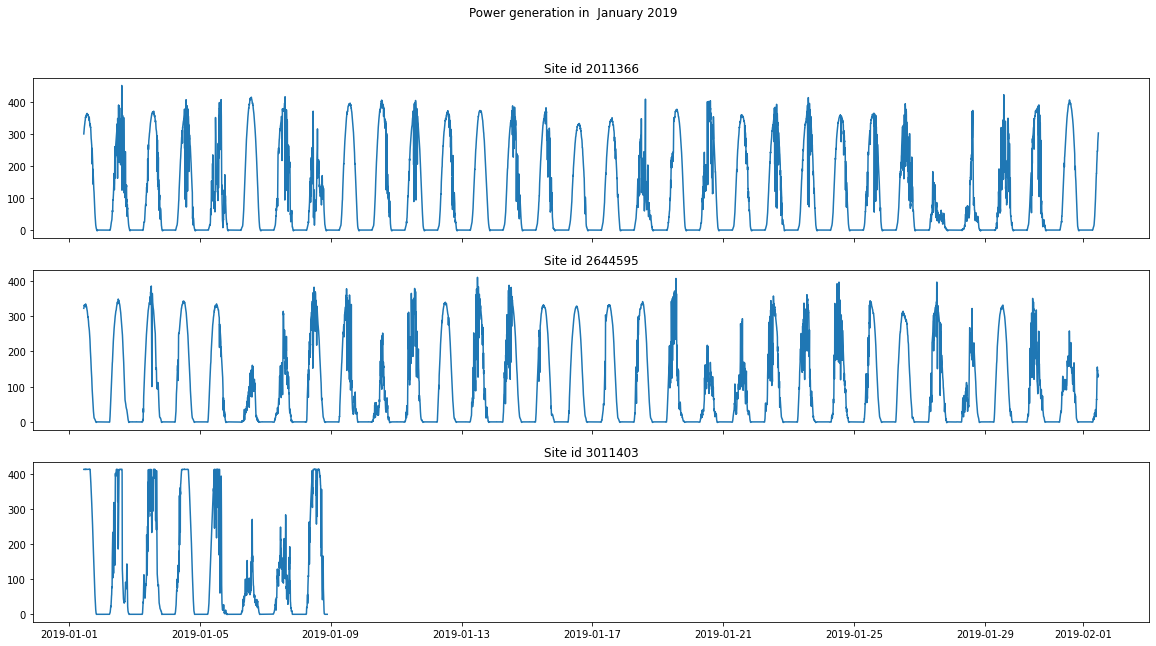

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True,figsize=(20,10))
fig.suptitle('Power generation in  January 2019')
ax1.plot(site_2011366[['local_timestamp']], site_2011366["energy_(Wh)"])
ax2.plot(site_2644595[['local_timestamp']], site_2644595["energy_(Wh)"])
ax3.plot(site_3011403[['local_timestamp']], site_3011403["energy_(Wh)"])

ax1.title.set_text('Site id 2011366')
ax2.title.set_text('Site id 2644595')
ax3.title.set_text('Site id 3011403')


It seems the overall trend is the same in different sites. Now, we want to investigate closely for the trend during the day by plotting January 3, 2019

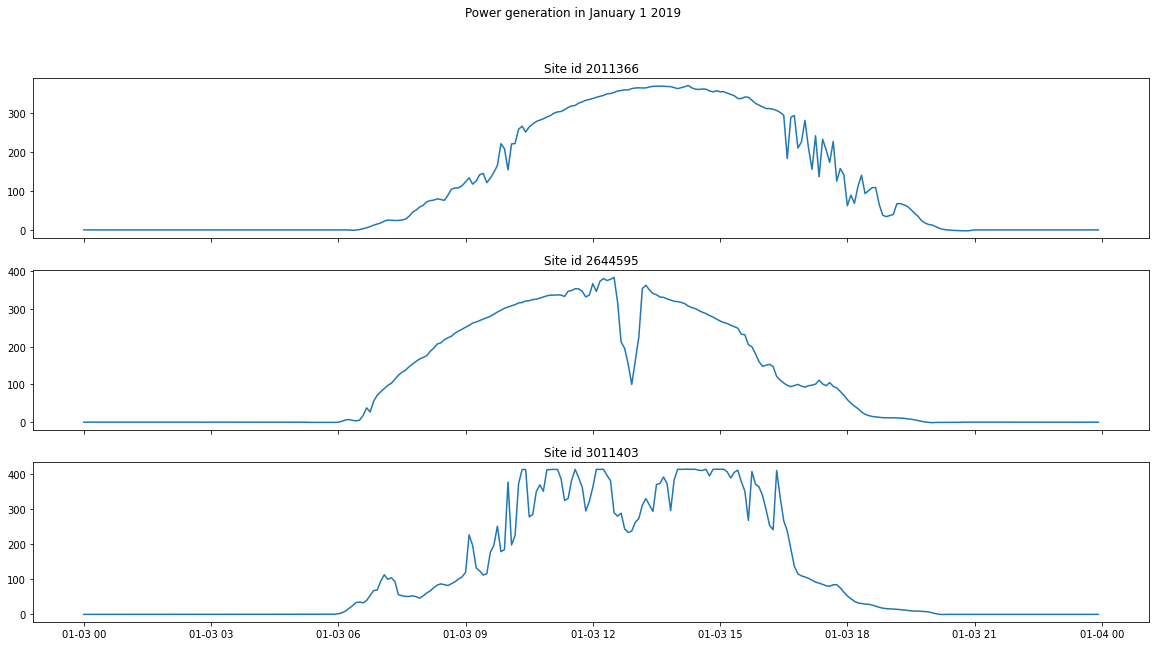

In [ ]:
site_2011366_day3 = site_2011366[site_2011366['local_timestamp'].dt.day==3]
site_2644595_day3 = site_2644595[site_2644595['local_timestamp'].dt.day==3]
site_3011403_day3 = site_3011403[site_3011403['local_timestamp'].dt.day==3]

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True,figsize=(20,10))
fig.suptitle('Power generation in January 1 2019')
ax1.plot(site_2011366_day3[['local_timestamp']], site_2011366_day3["energy_(Wh)"])
ax2.plot(site_2644595_day3[['local_timestamp']], site_2644595_day3["energy_(Wh)"])
ax3.plot(site_3011403_day3[['local_timestamp']], site_3011403_day3["energy_(Wh)"])

ax1.title.set_text('Site id 2011366')
ax2.title.set_text('Site id 2644595')
ax3.title.set_text('Site id 3011403')

Similarly, investigate more for the trend during the day by plotting January 6, 2019

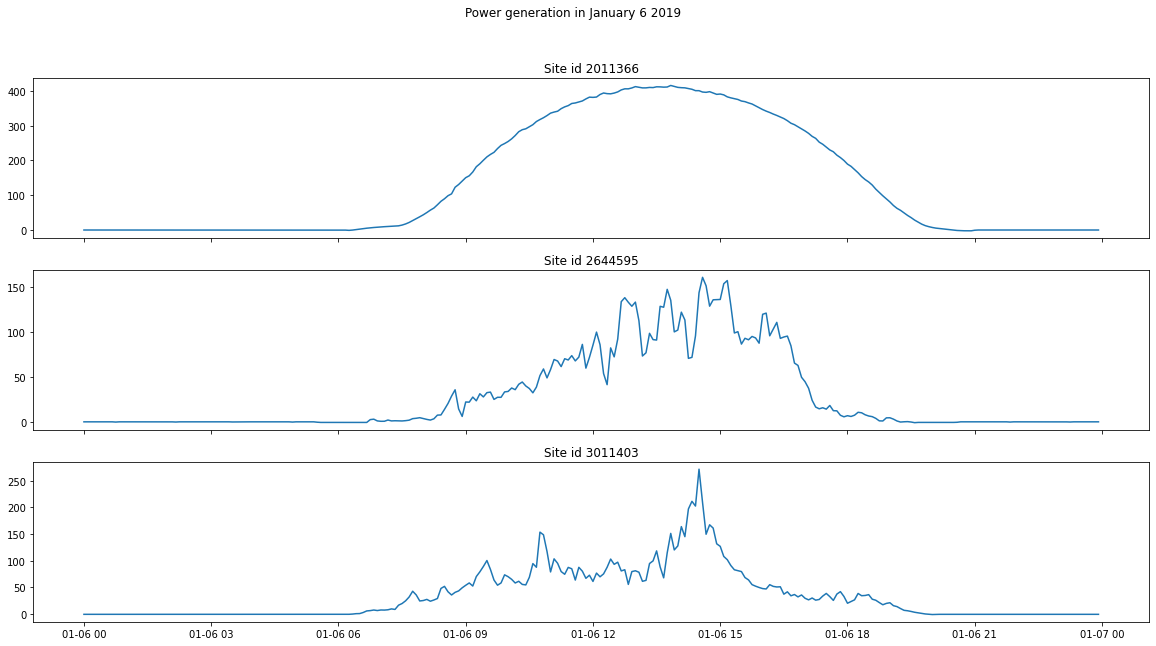

In [ ]:
site_2011366_day6 = site_2011366[site_2011366['local_timestamp'].dt.day==6]
site_2644595_day6 = site_2644595[site_2644595['local_timestamp'].dt.day==6]
site_3011403_day6 = site_3011403[site_3011403['local_timestamp'].dt.day==6]

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True,figsize=(20,10))
fig.suptitle('Power generation in January 6 2019')
ax1.plot(site_2011366_day6[['local_timestamp']], site_2011366_day6["energy_(Wh)"])
ax2.plot(site_2644595_day6[['local_timestamp']], site_2644595_day6["energy_(Wh)"])
ax3.plot(site_3011403_day6[['local_timestamp']], site_3011403_day6["energy_(Wh)"])

ax1.title.set_text('Site id 2011366')
ax2.title.set_text('Site id 2644595')
ax3.title.set_text('Site id 3011403')

Both two days have different fluctuating patterns during the day so it is interesting to see how the generated power values are distributed in both day and month periods.

In [ ]:
site_2011366['day'] = site_2011366['local_timestamp'].dt.day
site_2644595['day'] = site_2644595['local_timestamp'].dt.day
site_3011403['day'] = site_3011403['local_timestamp'].dt.day

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

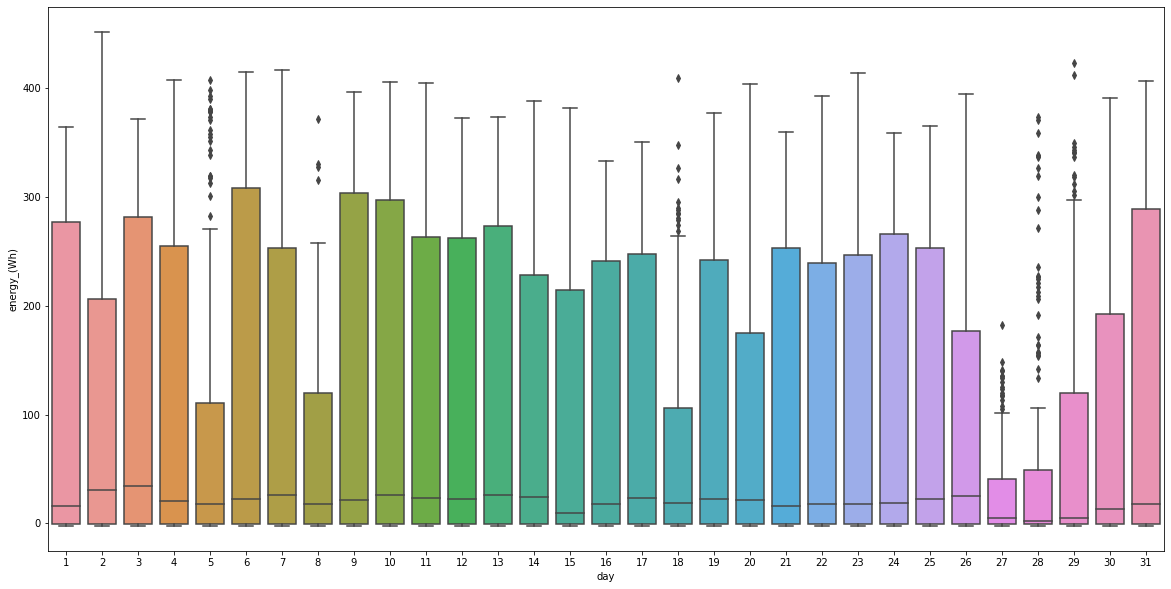

In [ ]:
plt.figure(figsize=(20,10))
sns.boxplot(x=site_2011366['day'],y=site_2011366["energy_(Wh)"])

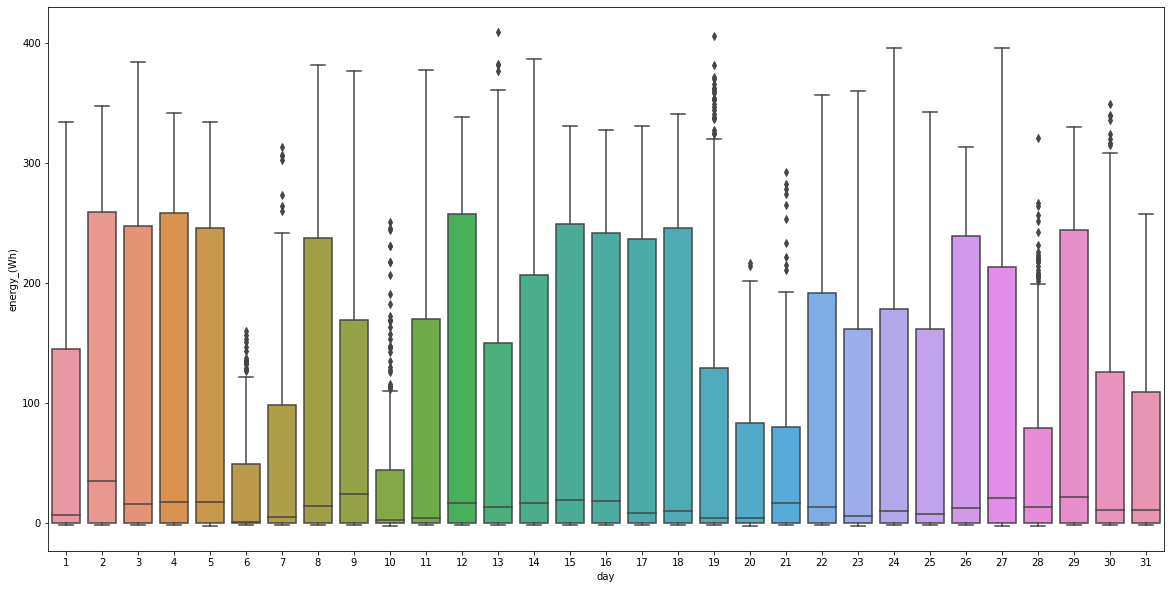

In [ ]:
plt.figure(figsize=(20,10))
sns.boxplot(x=site_2644595['day'],y=site_2644595["energy_(Wh)"])

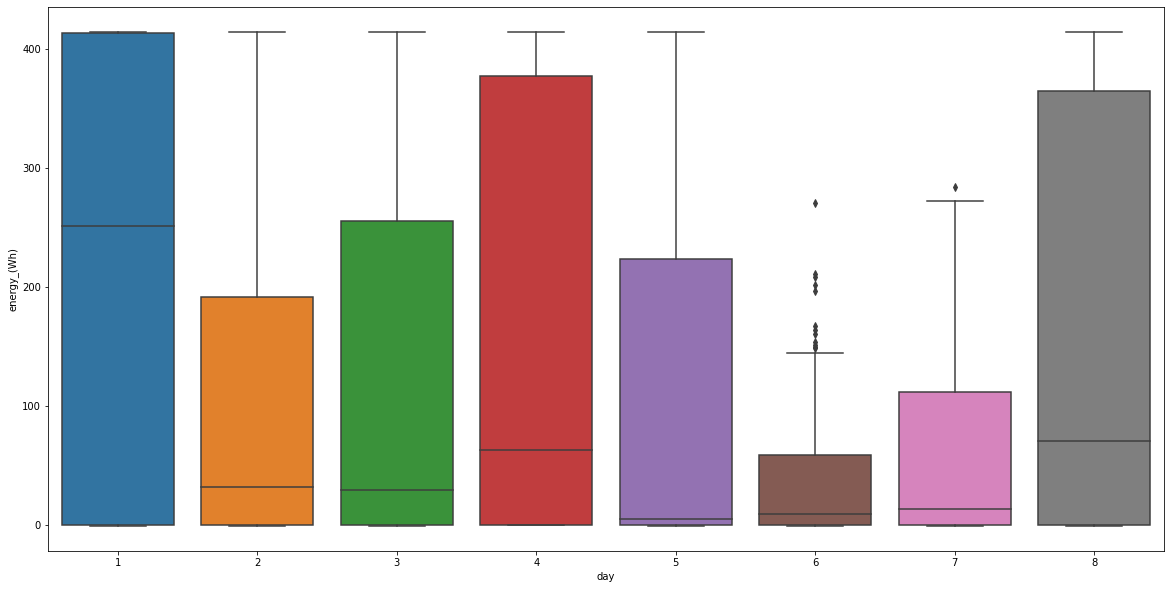

In [ ]:
plt.figure(figsize=(20,10))
sns.boxplot(x=site_3011403['day'],y=site_3011403["energy_(Wh)"])

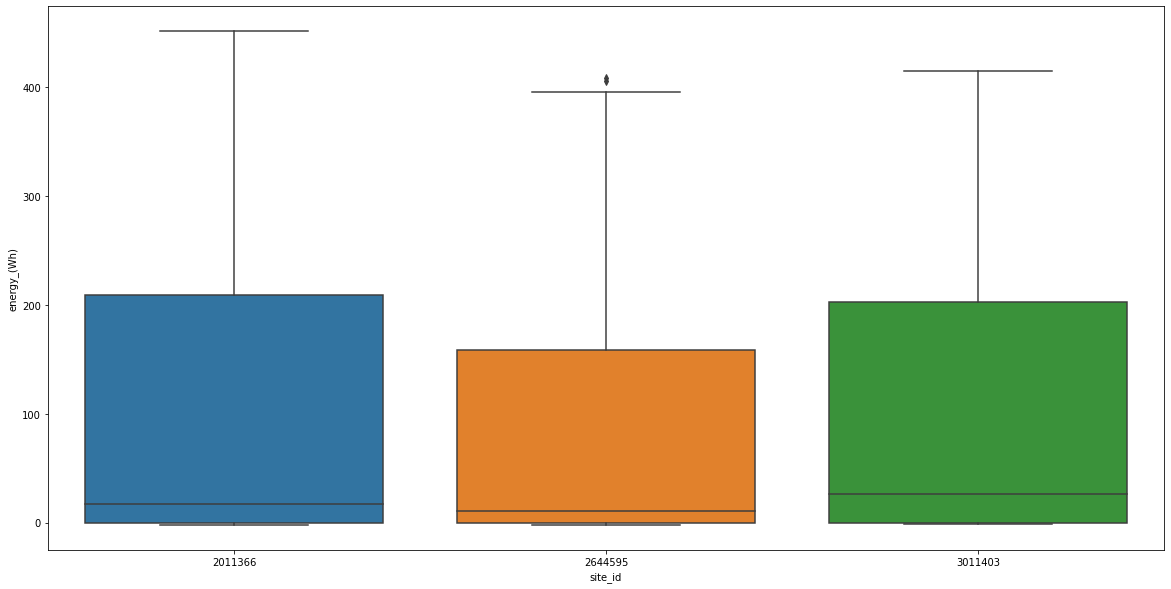

In [ ]:
plt.figure(figsize=(20,10))
sns.boxplot(x=df_merged.site_id,y=df_merged["energy_(Wh)"])

Now, we will start to explore the weather data. The weather parameters in January 2019 are profiled in the plot.

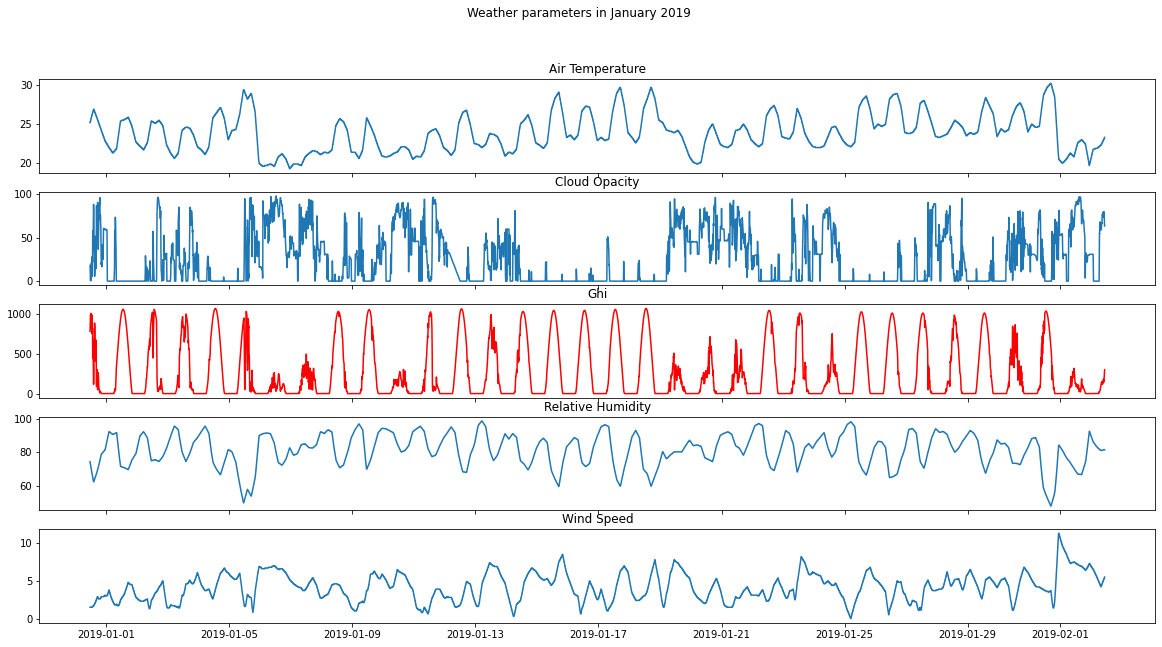

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex=True,figsize=(20,10))
fig.suptitle('Weather parameters in January 2019')
ax1.plot(df_weather_sydney[['local_timestamp']], df_weather_sydney["AirTemp"])
ax2.plot(df_weather_sydney[['local_timestamp']], df_weather_sydney["CloudOpacity"])
ax3.plot(df_weather_sydney[['local_timestamp']], df_weather_sydney["Ghi"], color ='red')
ax4.plot(df_weather_sydney[['local_timestamp']], df_weather_sydney["RelativeHumidity"])
ax5.plot(df_weather_sydney[['local_timestamp']], df_weather_sydney["WindSpeed10m"])

ax1.title.set_text('Air Temperature')
ax2.title.set_text('Cloud Opacity')
ax3.title.set_text('Ghi')
ax4.title.set_text('Relative Humidity')
ax5.title.set_text('Wind Speed')


It seems GHI has the same trend as the power generation but the other variables also have subtle similarity in pattern. Next, investigate a trend in different site IDs.

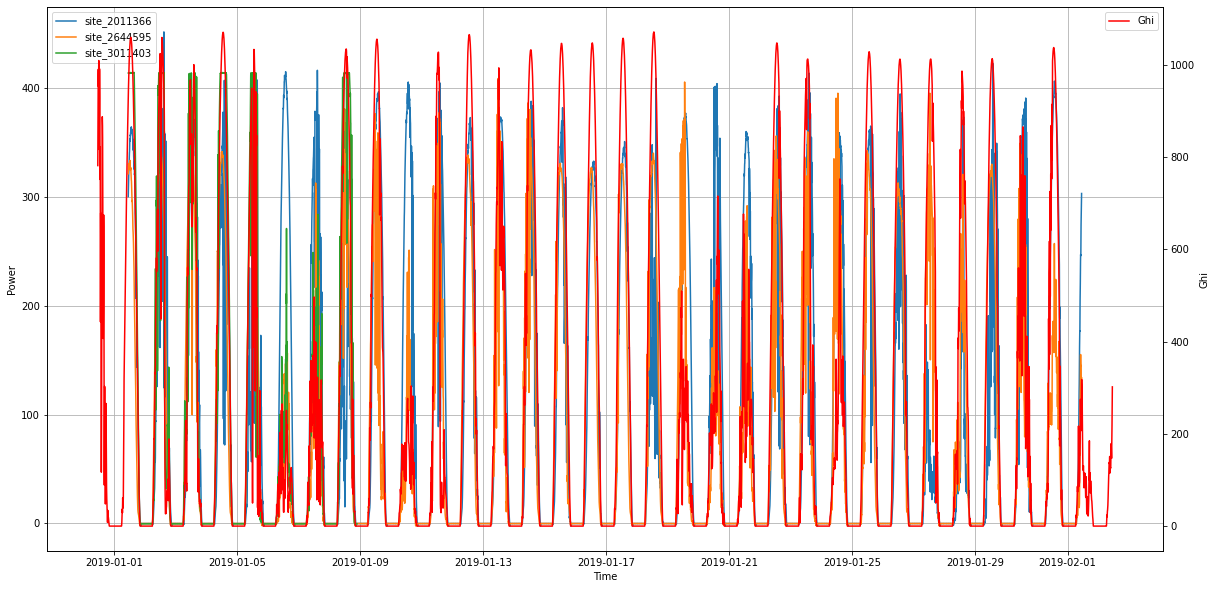

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(site_2011366[['local_timestamp']], site_2011366["energy_(Wh)"], label = 'site_2011366')
ax.plot(site_2644595[['local_timestamp']], site_2644595["energy_(Wh)"], label = 'site_2644595')
ax.plot(site_3011403[['local_timestamp']], site_3011403["energy_(Wh)"], label = 'site_3011403')
ax2 = ax.twinx()
ax2.plot(df_weather_sydney[['local_timestamp']], df_weather_sydney["Ghi"], label = 'Ghi', color= 'red')
ax.legend(loc=2)
ax2.legend(loc=0)
ax.grid()
ax.set_xlabel("Time")
ax.set_ylabel(r"Power")
ax2.set_ylabel(r"Ghi")

plt.show()

The plot is too difficult to see so we will look closely in the intra-day scale in Jan 3 and 6.

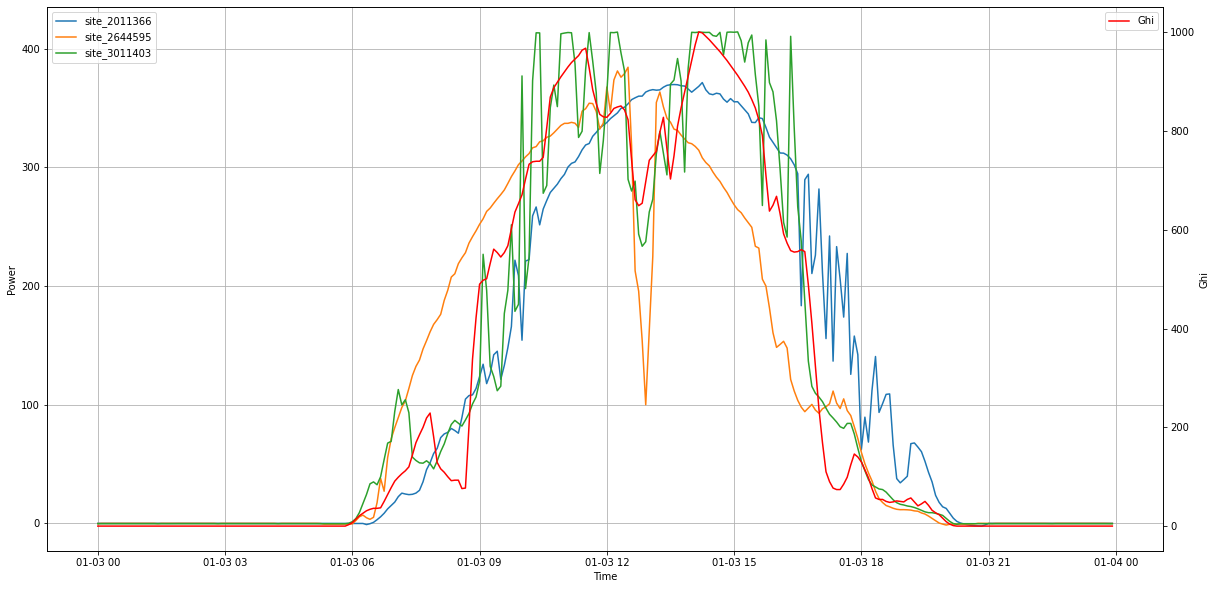

In [ ]:

df_weather_sydney_day3 = df_weather_sydney[df_weather_sydney['local_timestamp'].dt.day==3]

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(site_2011366_day3[['local_timestamp']], site_2011366_day3["energy_(Wh)"], label = 'site_2011366')
ax.plot(site_2644595_day3[['local_timestamp']], site_2644595_day3["energy_(Wh)"], label = 'site_2644595')
ax.plot(site_3011403_day3[['local_timestamp']], site_3011403_day3["energy_(Wh)"], label = 'site_3011403')
ax2 = ax.twinx()
ax2.plot(df_weather_sydney_day3['local_timestamp'], df_weather_sydney_day3['Ghi'], color='red', label = 'Ghi')
ax.legend(loc=2)
ax2.legend(loc=0)
ax.grid()
ax.set_xlabel("Time")
ax.set_ylabel(r"Power")
ax2.set_ylabel(r"Ghi")

plt.show()

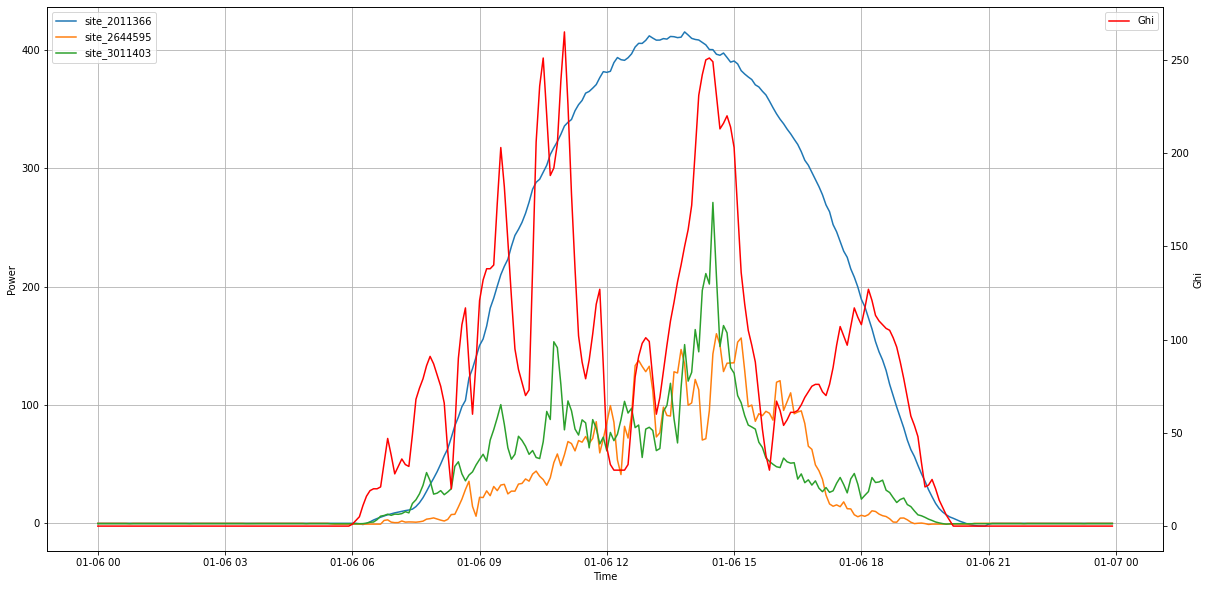

In [ ]:

df_weather_sydney_day6 = df_weather_sydney[df_weather_sydney['local_timestamp'].dt.day==6]

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(site_2011366_day6[['local_timestamp']], site_2011366_day6["energy_(Wh)"], label = 'site_2011366')
ax.plot(site_2644595_day6[['local_timestamp']], site_2644595_day6["energy_(Wh)"], label = 'site_2644595')
ax.plot(site_3011403_day6[['local_timestamp']], site_3011403_day6["energy_(Wh)"], label = 'site_3011403')
ax2 = ax.twinx()
ax2.plot(df_weather_sydney_day6['local_timestamp'], df_weather_sydney_day6['Ghi'], color='red', label = 'Ghi')
ax.legend(loc=2)
ax2.legend(loc=0)
ax.grid()
ax.set_xlabel("Time")
ax.set_ylabel(r"Power")
ax2.set_ylabel(r"Ghi")

plt.show()

All power outputs in the three locations have very similar trend as the GHI in both plotted days except for the site ID of 2011366 represented in the blue line. So I want to check how far these site IDs are from each other as they might get different levels of solar exposure.

In [ ]:
pip install pgeocode

In [ ]:
#plot postcode
import pgeocode
import plotly.express as px

In [ ]:
nomi = pgeocode.Nominatim('au')
#nomi.query_postal_code("4000")

In [ ]:
# extract the postcodes from the three site IDs
series_postcode = df_merged['postcode'].unique()
series_postcode = series_postcode[~np.isnan(series_postcode)]
series_postcode = series_postcode.astype(int)
df_postcode = pd.DataFrame(series_postcode, columns = ['PostCode']) 
df_postcode

,PostCode
0,2680
1,2284


Unfortunately, one site's postcode is missing but the post code of site ID 2011366 that had different trend earlier is still available.

In [ ]:
# get the coordinates on the world map
df_postcode["latitude"] = df_postcode["PostCode"].apply(lambda x: nomi.query_postal_code(x)[9])
df_postcode["longitude"] = df_postcode["PostCode"].apply(lambda x: nomi.query_postal_code(x)[10])
df_postcode

,PostCode,latitude,longitude
0,2680,-34.5516,146.017306
1,2284,-32.9506,151.617357


In [ ]:
fig = px.scatter_mapbox(df_postcode, lat="latitude", lon="longitude", zoom=3, height=300, size_max = 30)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

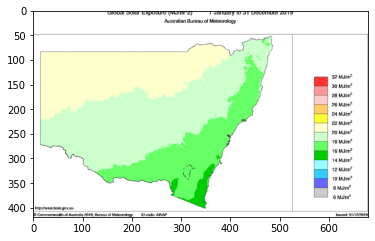

In [ ]:
img = mpimg.imread("/content/drive/My Drive/IFN703_advanced_project/solar exposure.gif")
plt.imshow(img)

The site 2011366 is located far away from Sydney which is where the weather data was measured and according to the heat map, it gets different level of solar exposure. Next, I want to see how the effect of solar radiation are different across the three sites thus I plot correlation plots.

In [ ]:
#correlation plot
site_2011366_weather = pd.merge(site_2011366, df_weather_sydney, left_on='local_timestamp', right_on='local_timestamp', how = 'left')
site_2011366_weather.head()

,t_stamp_utc,site_id,energy_(Wh),voltage_max_(V),voltage_min_(V),postcode,state,timezone_id,local_timestamp,day,PeriodEnd,PeriodStart,Period,AirTemp,CloudOpacity,Ghi,RelativeHumidity,WindSpeed10m
0,2019-01-01 00:00:00+00:00,2011366,300.4561,240.6,239.7,2680.0,NSW,Australia/Sydney,2019-01-01 11:00:00,1,2019-01-01 00:00:00+00:00,2018-12-31T23:55:00Z,PT5M,25.4,0.0,928,71.9,2.4
1,2019-01-01 00:05:00+00:00,2011366,305.3942,240.5,238.3,2680.0,NSW,Australia/Sydney,2019-01-01 11:05:00,1,2019-01-01 00:05:00+00:00,2019-01-01T00:00:00Z,PT5M,25.4,0.0,939,71.7,2.5
2,2019-01-01 00:10:00+00:00,2011366,308.3975,239.9,238.6,2680.0,NSW,Australia/Sydney,2019-01-01 11:10:00,1,2019-01-01 00:10:00+00:00,2019-01-01T00:05:00Z,PT5M,25.4,0.0,949,71.6,2.5
3,2019-01-01 00:15:00+00:00,2011366,313.6281,238.6,237.6,2680.0,NSW,Australia/Sydney,2019-01-01 11:15:00,1,2019-01-01 00:15:00+00:00,2019-01-01T00:10:00Z,PT5M,25.4,0.0,959,71.6,2.5
4,2019-01-01 00:20:00+00:00,2011366,318.1089,238.6,237.3,2680.0,NSW,Australia/Sydney,2019-01-01 11:20:00,1,2019-01-01 00:20:00+00:00,2019-01-01T00:15:00Z,PT5M,25.4,0.0,969,71.5,2.6


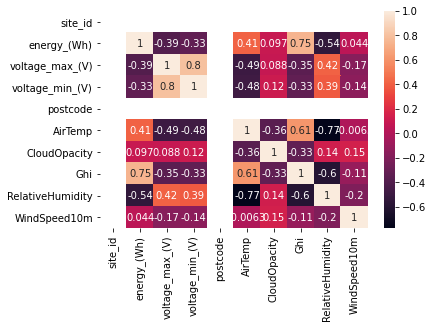

In [ ]:
site_2011366_weather = site_2011366_weather.drop(columns = ['t_stamp_utc','state','timezone_id','day','PeriodEnd','PeriodStart','Period'])
correlation_mat1 = site_2011366_weather.corr()
sns.heatmap(correlation_mat1, annot = True)
plt.show()

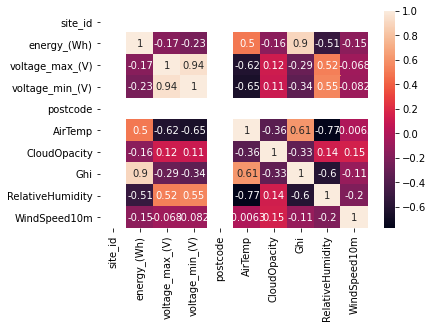

In [ ]:
site_2644595_weather = pd.merge(site_2644595, df_weather_sydney, left_on='local_timestamp', right_on='local_timestamp', how = 'left')
site_2644595_weather = site_2644595_weather.drop(columns = ['t_stamp_utc','state','timezone_id','day','PeriodEnd','PeriodStart','Period'])
correlation_mat2 = site_2644595_weather.corr()
sns.heatmap(correlation_mat2, annot = True)
plt.show()

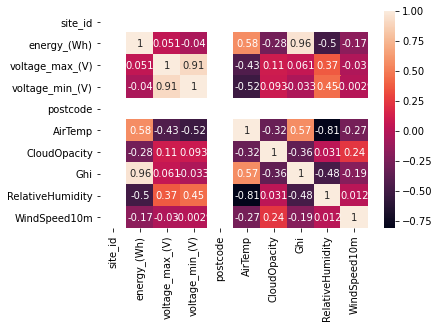

In [ ]:
site_3011403_weather = pd.merge(site_3011403, df_weather_sydney, left_on='local_timestamp', right_on='local_timestamp', how = 'left')
site_3011403_weather = site_3011403_weather.drop(columns = ['t_stamp_utc','state','timezone_id','day','PeriodEnd','PeriodStart','Period'])
correlation_mat3 = site_3011403_weather.corr()
sns.heatmap(correlation_mat3, annot = True)
plt.show()

The three sites have different levels of correlation with GHI. This probably means that at different site location we will have different correlation with weather variables. In order to confirm this hypothesis, I try to conduct Bacward stepwise regression in the three sites to see if the significant weather variables (at 95% confident level) are different.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
import statsmodels.regression.linear_model as sm 

site_2011366_weather_X = site_2011366_weather[['voltage_max_(V)', 'voltage_min_(V)', 'AirTemp', 'CloudOpacity', 'Ghi','RelativeHumidity', 'WindSpeed10m']]
site_2011366_weather_Y = site_2011366_weather['energy_(Wh)']

x_train, x_test, y_train, y_test = train_test_split( 
        site_2011366_weather_X, site_2011366_weather_Y, test_size = 0.3, random_state = 0) 

lm = LinearRegression() 
lm.fit(x_train, y_train) 
pred = lm.predict(x_test) 

# add a column of ones as integer data type 
x = np.append(arr = np.ones([x_train.shape[0],1]).astype(int),  
              values = x_train, axis = 1) 
# choose a Significance level usually 0.05, if p>0.05 
#  for the highest values parameter, remove that value 
x_opt = x[:, [0, 1, 2, 3, 4, 5, 6, 7]] 
ols = sm.OLS(endog = y_train, exog = x_opt).fit() 
ols.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            energy_(Wh)   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     2311.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):               0.00
Time:                        15:28:20   Log-Likelihood:                -35476.
No. Observations:                6249   AIC:                         7.097e+04
Df Residuals:                    6241   BIC:                         7.102e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2154.2260    123.709     17.414      0.000    1911.714    2396.738
x1            -7.4150      0.668    -11.092      0.000      -8.725      -6.104
x2            -0.1069      0.585     -0.183      0.855      -1.253       1.040
x3            -8.2261      0.725    -11.347      0.000      -9.647      -6.805
x4             1.6110      0.036     44.214      0.000       1.540       1.682
x5             0.3085      0.003     88.411      0.000       0.302       0.315
x6            -2.1804      0.172    -12.647      0.000      -2.518      -1.842
x7             2.0188      0.560      3.605      0.000       0.921       3.117
==============================================================================
Omnibus:                      166.888   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              408.850
Skew:                          -0.038   Prob(JB):                     1.66e-89
Kurtosis:                       4.251   Cond. No.                     7.01e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
x_opt = x[:, [0, 1, 3, 4, 5, 6, 7]] 
ols = sm.OLS(endog = y_train, exog = x_opt).fit() 
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            energy_(Wh)   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     2697.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):               0.00
Time:                        15:28:20   Log-Likelihood:                -35476.
No. Observations:                6249   AIC:                         7.097e+04
Df Residuals:                    6242   BIC:                         7.101e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2149.5713    121.048     17.758      0.000    1912.275    2386.868
x1            -7.5036      0.460    -16.323      0.000      -8.405      -6.602
x2            -8.2090      0.719    -11.420      0.000      -9.618      -6.800
x3             1.6109      0.036     44.219      0.000       1.539       1.682
x4             0.3085      0.003     88.417      0.000       0.302       0.315
x5            -2.1790      0.172    -12.653      0.000      -2.517      -1.841
x6             2.0235      0.559      3.617      0.000       0.927       3.120
==============================================================================
Omnibus:                      166.872   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              408.684
Skew:                          -0.038   Prob(JB):                     1.80e-89
Kurtosis:                       4.251   Cond. No.                     6.39e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

For the first site, minimum voltage variable was not selected.

In [ ]:
site_2644595_weather = site_2644595_weather.dropna()
site_2644595_weather_X = site_2644595_weather[['voltage_max_(V)', 'voltage_min_(V)', 'AirTemp', 'CloudOpacity', 'Ghi','RelativeHumidity', 'WindSpeed10m']]
site_2644595_weather_Y = site_2644595_weather['energy_(Wh)']

x_train, x_test, y_train, y_test = train_test_split( 
        site_2644595_weather_X, site_2644595_weather_Y, test_size = 0.3, random_state = 0) 

lm = LinearRegression() 
lm.fit(x_train, y_train) 
pred = lm.predict(x_test) 

# add a column of ones as integer data type 
x = np.append(arr = np.ones([x_train.shape[0],1]).astype(int),  
              values = x_train, axis = 1) 
# choose a Significance level usually 0.05, if p>0.05 
#  for the highest values parameter, remove that value 
x_opt = x[:, [0, 1, 2, 3, 4, 5, 6, 7]] 
ols = sm.OLS(endog = y_train, exog = x_opt).fit() 
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            energy_(Wh)   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     4695.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):               0.00
Time:                        15:28:20   Log-Likelihood:                -32869.
No. Observations:                6248   AIC:                         6.575e+04
Df Residuals:                    6240   BIC:                         6.581e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1449.6291     90.559    -16.008      0.000   -1627.156   -1272.102
x1             6.7337      0.822      8.197      0.000       5.123       8.344
x2            -0.9510      0.782     -1.217      0.224      -2.483       0.581
x3             2.2370      0.498      4.490      0.000       1.260       3.214
x4             0.7154      0.024     29.916      0.000       0.669       0.762
x5             0.3124      0.002    134.863      0.000       0.308       0.317
x6            -0.0843      0.113     -0.747      0.455      -0.306       0.137
x7            -4.5792      0.363    -12.623      0.000      -5.290      -3.868
==============================================================================
Omnibus:                     1285.031   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7670.628
Skew:                           0.850   Prob(JB):                         0.00
Kurtosis:                       8.155   Cond. No.                     7.80e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
x_opt = x[:, [0, 1, 2, 3, 4, 5, 7]] 
ols = sm.OLS(endog = y_train, exog = x_opt).fit() 
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            energy_(Wh)   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     5478.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):               0.00
Time:                        15:28:20   Log-Likelihood:                -32870.
No. Observations:                6248   AIC:                         6.575e+04
Df Residuals:                    6241   BIC:                         6.580e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1457.1367     89.996    -16.191      0.000   -1633.560   -1280.714
x1             6.6988      0.820      8.168      0.000       5.091       8.307
x2            -0.9375      0.781     -1.200      0.230      -2.469       0.594
x3             2.4550      0.404      6.081      0.000       1.664       3.246
x4             0.7199      0.023     31.106      0.000       0.675       0.765
x5             0.3130      0.002    144.097      0.000       0.309       0.317
x6            -4.4828      0.339    -13.223      0.000      -5.147      -3.818
==============================================================================
Omnibus:                     1284.506   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7645.046
Skew:                           0.851   Prob(JB):                         0.00
Kurtosis:                       8.145   Cond. No.                     7.69e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
x_opt = x[:, [0, 1, 3, 4, 5, 7]] 
ols = sm.OLS(endog = y_train, exog = x_opt).fit() 
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            energy_(Wh)   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     6573.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):               0.00
Time:                        15:28:20   Log-Likelihood:                -32870.
No. Observations:                6248   AIC:                         6.575e+04
Df Residuals:                    6242   BIC:                         6.579e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1468.5622     89.494    -16.410      0.000   -1644.001   -1293.124
x1             5.8049      0.343     16.938      0.000       5.133       6.477
x2             2.5406      0.397      6.394      0.000       1.762       3.320
x3             0.7233      0.023     31.490      0.000       0.678       0.768
x4             0.3133      0.002    145.259      0.000       0.309       0.318
x5            -4.4588      0.338    -13.175      0.000      -5.122      -3.795
==============================================================================
Omnibus:                     1290.735   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7651.452
Skew:                           0.857   Prob(JB):                         0.00
Kurtosis:                       8.144   Cond. No.                     7.11e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

For the second one, minimum voltage and RH were not selected.

In [ ]:
#site_3011403_weather
site_3011403_weather_X = site_3011403_weather[['voltage_max_(V)', 'voltage_min_(V)', 'AirTemp', 'CloudOpacity', 'Ghi','RelativeHumidity', 'WindSpeed10m']]
site_3011403_weather_Y = site_3011403_weather['energy_(Wh)']

x_train, x_test, y_train, y_test = train_test_split( 
        site_3011403_weather_X, site_3011403_weather_Y, test_size = 0.3, random_state = 0) 

lm = LinearRegression() 
lm.fit(x_train, y_train) 
pred = lm.predict(x_test) 

# add a column of ones as integer data type 
x = np.append(arr = np.ones([x_train.shape[0],1]).astype(int),  
              values = x_train, axis = 1) 
# choose a Significance level usually 0.05, if p>0.05 
#  for the highest values parameter, remove that value 
x_opt = x[:, [0, 1, 2, 3, 4, 5, 6, 7]] 
ols = sm.OLS(endog = y_train, exog = x_opt).fit() 
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            energy_(Wh)   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     2460.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):               0.00
Time:                        15:28:20   Log-Likelihood:                -7770.4
No. Observations:                1500   AIC:                         1.556e+04
Df Residuals:                    1492   BIC:                         1.560e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -351.3971    178.185     -1.972      0.049    -700.918      -1.877
x1            -1.6556      1.425     -1.162      0.245      -4.450       1.139
x2             2.7226      1.284      2.120      0.034       0.204       5.242
x3             4.4825      1.079      4.155      0.000       2.366       6.599
x4             0.4197      0.044      9.484      0.000       0.333       0.507
x5             0.4102      0.004     92.308      0.000       0.401       0.419
x6            -0.1016      0.226     -0.451      0.652      -0.544       0.341
x7             0.9437      0.826      1.143      0.253      -0.676       2.564
==============================================================================
Omnibus:                      344.603   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14888.013
Skew:                           0.118   Prob(JB):                         0.00
Kurtosis:                      18.432   Cond. No.                     7.98e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.98e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
x_opt = x[:, [0, 1, 2, 3, 4, 5, 7]] 
ols = sm.OLS(endog = y_train, exog = x_opt).fit() 
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            energy_(Wh)   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     2871.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):               0.00
Time:                        15:28:20   Log-Likelihood:                -7770.5
No. Observations:                1500   AIC:                         1.556e+04
Df Residuals:                    1493   BIC:                         1.559e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -364.2808    175.830     -2.072      0.038    -709.181     -19.381
x1            -1.7134      1.418     -1.208      0.227      -4.496       1.069
x2             2.7626      1.281      2.157      0.031       0.250       5.275
x3             4.8420      0.726      6.668      0.000       3.418       6.266
x4             0.4280      0.040     10.636      0.000       0.349       0.507
x5             0.4105      0.004     93.504      0.000       0.402       0.419
x6             1.0637      0.782      1.361      0.174      -0.469       2.597
==============================================================================
Omnibus:                      345.188   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14852.709
Skew:                           0.131   Prob(JB):                         0.00
Kurtosis:                      18.413   Cond. No.                     7.81e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
x_opt = x[:, [0, 2, 3, 4, 5, 7]] 
ols = sm.OLS(endog = y_train, exog = x_opt).fit() 
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            energy_(Wh)   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     3444.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):               0.00
Time:                        15:28:20   Log-Likelihood:                -7771.2
No. Observations:                1500   AIC:                         1.555e+04
Df Residuals:                    1494   BIC:                         1.559e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -453.8469    159.456     -2.846      0.004    -766.629    -141.065
x1             1.4117      0.624      2.261      0.024       0.187       2.636
x2             4.8550      0.726      6.686      0.000       3.431       6.279
x3             0.4199      0.040     10.582      0.000       0.342       0.498
x4             0.4094      0.004     95.357      0.000       0.401       0.418
x5             1.1085      0.781      1.420      0.156      -0.423       2.640
==============================================================================
Omnibus:                      344.825   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14823.099
Skew:                           0.127   Prob(JB):                         0.00
Kurtosis:                      18.398   Cond. No.                     6.59e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
x_opt = x[:, [0, 2, 3, 4, 5]] 
ols = sm.OLS(endog = y_train, exog = x_opt).fit() 
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            energy_(Wh)   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     4302.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):               0.00
Time:                        15:28:20   Log-Likelihood:                -7772.3
No. Observations:                1500   AIC:                         1.555e+04
Df Residuals:                    1495   BIC:                         1.558e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -404.8050    155.722     -2.600      0.009    -710.263     -99.347
x1             1.2504      0.614      2.036      0.042       0.046       2.455
x2             4.5722      0.699      6.546      0.000       3.202       5.942
x3             0.4283      0.039     10.913      0.000       0.351       0.505
x4             0.4098      0.004     95.688      0.000       0.401       0.418
==============================================================================
Omnibus:                      341.199   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14555.315
Skew:                           0.086   Prob(JB):                         0.00
Kurtosis:                      18.260   Cond. No.                     6.43e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

For the third site, minimum voltage, RH, and wind speed were not selected. As a result, we can say that the assumption is true.

# Data Pre-processing

From now on, we will start working with the whole data set so every file is combines and load into our environment and pre-process similar to the first 20k rows.

In [ ]:
#combine data sets
#os.chdir("/content/drive/My Drive/IFN703_advanced_project")
#all_filenames = ['2019-01.csv','2019-02.csv','2019-03.csv','2019-04.csv','2019-05.csv','2019-06.csv','2019-07.csv','2019-08.csv','2019-09.csv','2019-10.csv','2019-11.csv','2019-12.csv',]
#extension = 'csv'
#all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
#combine all files in the list
#combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
#combined_csv.to_csv( "combined_data.csv", index=False, encoding='utf-8-sig')

In [ ]:
df_combined_data = pd.read_csv("/content/drive/My Drive/IFN703_advanced_project/combined_data.csv")
df_combined_data.head()

,t_stamp_utc,site_id,energy_(Wh),voltage_max_(V),voltage_min_(V)
0,2019-01-01 00:00:00+00:00,2011366,300.4561,240.6,239.7
1,2019-01-01 00:05:00+00:00,2011366,305.3942,240.5,238.3
2,2019-01-01 00:10:00+00:00,2011366,308.3975,239.9,238.6
3,2019-01-01 00:15:00+00:00,2011366,313.6281,238.6,237.6
4,2019-01-01 00:20:00+00:00,2011366,318.1089,238.6,237.3


In [ ]:
df_combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105406509 entries, 0 to 105406508
Data columns (total 5 columns):
 #   Column           Dtype  
---  ------           -----  
 0   t_stamp_utc      object 
 1   site_id          int64  
 2   energy_(Wh)      float64
 3   voltage_max_(V)  float64
 4   voltage_min_(V)  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 3.9+ GB


In [ ]:
# merge combined data with site_details
df_merged = pd.merge(df_combined_data,site_details, on='site_id')
df_merged.head()

,t_stamp_utc,site_id,energy_(Wh),voltage_max_(V),voltage_min_(V),postcode,state,timezone_id
0,2019-01-01 00:00:00+00:00,2011366,300.4561,240.6,239.7,2680,NSW,Australia/Sydney
1,2019-01-01 00:05:00+00:00,2011366,305.3942,240.5,238.3,2680,NSW,Australia/Sydney
2,2019-01-01 00:10:00+00:00,2011366,308.3975,239.9,238.6,2680,NSW,Australia/Sydney
3,2019-01-01 00:15:00+00:00,2011366,313.6281,238.6,237.6,2680,NSW,Australia/Sydney
4,2019-01-01 00:20:00+00:00,2011366,318.1089,238.6,237.3,2680,NSW,Australia/Sydney


In [ ]:
#select only the record in Brisbane time zone
data_brisbane = df_merged[df_merged['timezone_id'] == 'Australia/Brisbane']
data_brisbane.head()

,t_stamp_utc,site_id,energy_(Wh),voltage_max_(V),voltage_min_(V),postcode,state,timezone_id
210818,2019-01-01 00:00:00+00:00,6103020,251.3603,247.8,244.8,4702,QLD,Australia/Brisbane
210819,2019-01-01 00:05:00+00:00,6103020,123.4781,244.8,243.8,4702,QLD,Australia/Brisbane
210820,2019-01-01 00:10:00+00:00,6103020,256.5881,248.0,244.5,4702,QLD,Australia/Brisbane
210821,2019-01-01 00:15:00+00:00,6103020,339.5414,247.9,245.5,4702,QLD,Australia/Brisbane
210822,2019-01-01 00:20:00+00:00,6103020,285.1503,247.4,244.3,4702,QLD,Australia/Brisbane


In [ ]:
data_brisbane.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503228 entries, 210818 to 89276958
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   t_stamp_utc      object 
 1   site_id          int64  
 2   energy_(Wh)      float64
 3   voltage_max_(V)  float64
 4   voltage_min_(V)  float64
 5   postcode         int64  
 6   state            object 
 7   timezone_id      object 
dtypes: float64(3), int64(2), object(3)
memory usage: 1.4+ GB


In [ ]:
#convert t_stamp_utc column into datetime format
data_brisbane['t_stamp_utc'] = pd.to_datetime(data_brisbane['t_stamp_utc'])
#convert UTC into the local time zone
data_brisbane['local_timestamp'] = data_brisbane['t_stamp_utc'].apply(lambda x:x.tz_convert('Australia/Brisbane').tz_localize(None))
data_brisbane.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,t_stamp_utc,site_id,energy_(Wh),voltage_max_(V),voltage_min_(V),postcode,state,timezone_id,local_timestamp
210818,2019-01-01 00:00:00+00:00,6103020,251.3603,247.8,244.8,4702,QLD,Australia/Brisbane,2019-01-01 10:00:00
210819,2019-01-01 00:05:00+00:00,6103020,123.4781,244.8,243.8,4702,QLD,Australia/Brisbane,2019-01-01 10:05:00
210820,2019-01-01 00:10:00+00:00,6103020,256.5881,248.0,244.5,4702,QLD,Australia/Brisbane,2019-01-01 10:10:00
210821,2019-01-01 00:15:00+00:00,6103020,339.5414,247.9,245.5,4702,QLD,Australia/Brisbane,2019-01-01 10:15:00
210822,2019-01-01 00:20:00+00:00,6103020,285.1503,247.4,244.3,4702,QLD,Australia/Brisbane,2019-01-01 10:20:00


In [ ]:
data_brisbane.describe()

,site_id,energy_(Wh),voltage_max_(V),voltage_min_(V),postcode
count,2.150323e+07,2.150323e+07,2.147761e+07,2.147761e+07,2.150323e+07
mean,1.087418e+09,8.089303e+01,2.431698e+02,2.404950e+02,4.320192e+03
std,6.173075e+08,1.213195e+02,4.549587e+00,4.711107e+00,2.341819e+02
min,6.103020e+06,-8.341564e+02,4.700000e+01,2.660000e+01,4.012000e+03
25%,5.865037e+08,-5.440000e-02,2.403000e+02,2.376000e+02,4.133000e+03
50%,1.052902e+09,1.953000e-01,2.435000e+02,2.409000e+02,4.220000e+03
75%,1.618214e+09,1.417742e+02,2.462000e+02,2.437000e+02,4.511000e+03
max,2.147462e+09,8.358344e+02,2.991000e+02,2.649000e+02,4.879000e+03


In [ ]:
data_brisbane['site_id'].unique()

array([   6103020,   17741532,   23802476,   40919374,   45034994,
         46273932,   51254079,   60993991,   77491219,   92071696,
        104989603,  126283799,  129936914,  131097238,  133852058,
        173994775,  186331009,  230589246,  230966412,  241271752,
        243548097,  264445722,  315622138,  327993590,  333578417,
        355817239,  366732948,  372817007,  373739408,  396552888,
        402468830,  408450837,  411999235,  419674474,  429924320,
        437606745,  454333399,  456964842,  459991966,  460805291,
        468485328,  485993539,  487359656,  493288080,  502373274,
        513054730,  514248804,  523047866,  558829996,  569311199,
        577341905,  586503715,  586527755,  593507228,  602393300,
        603579184,  609185751,  617523956,  651423412,  657276703,
        671090503,  671282194,  671621059,  677333055,  689045440,
        717470730,  731480064,  750212792,  758907147,  762981793,
        768946863,  786801023,  797841169,  807568245,  809748

In [ ]:
series_postcode_brisbane = data_brisbane['postcode'].unique()
series_postcode_brisbane = series_postcode_brisbane[~np.isnan(series_postcode_brisbane)]

df_postcode_brisbane = pd.DataFrame(series_postcode_brisbane, columns = ['PostCode']) 
#df_postcode_brisbane
df_postcode_brisbane["latitude"] = df_postcode_brisbane["PostCode"].apply(lambda x: nomi.query_postal_code(x)[9])
df_postcode_brisbane["longitude"] = df_postcode_brisbane["PostCode"].apply(lambda x: nomi.query_postal_code(x)[10])
df_postcode_brisbane

,PostCode,latitude,longitude
0,4702,-23.4914,149.723299
1,4564,-26.6311,153.087125
2,4017,-27.3264,153.060175
3,4209,-27.8486,153.302750
4,4304,-27.6070,152.802171
...,...,...,...
109,4705,-22.8342,149.314480
110,4737,-21.4208,149.205688
111,4799,-20.6807,148.658250
112,4555,-26.7145,152.947800


In [ ]:
fig = px.scatter_mapbox(df_postcode_brisbane, lat="latitude", lon="longitude", zoom=3, height=300,hover_name = 'PostCode', size_max = 30,color_discrete_sequence=["fuchsia"])
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

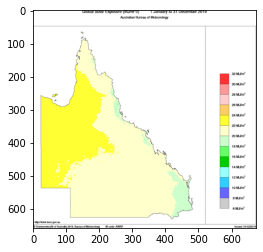

In [ ]:
img = mpimg.imread("/content/drive/My Drive/IFN703_advanced_project/solar_exposure_qld.gif")
plt.imshow(img)

As we discovered in the exploratory step, we will choose the site which has the same level of solar exposure with the ontained weather data set which was measured in Brisbane. I choose Holland Park because it is the closest suburb to Brisbane CBD in the data set.

In [ ]:
#select the sites of postcode 4121 and the site id associated with it is 396552888 from the brisbane dataframe
data_selected_site_id = data_brisbane[data_brisbane['site_id']==396552888]
data_selected_site_id.tail()

,t_stamp_utc,site_id,energy_(Wh),voltage_max_(V),voltage_min_(V),postcode,state,timezone_id,local_timestamp
16860974,2019-12-31 23:35:00+00:00,396552888,383.6394,244.2,241.3,4121,QLD,Australia/Brisbane,2020-01-01 09:35:00
16860975,2019-12-31 23:40:00+00:00,396552888,393.1939,244.4,239.8,4121,QLD,Australia/Brisbane,2020-01-01 09:40:00
16860976,2019-12-31 23:45:00+00:00,396552888,385.5344,242.3,238.1,4121,QLD,Australia/Brisbane,2020-01-01 09:45:00
16860977,2019-12-31 23:50:00+00:00,396552888,252.2833,241.9,236.4,4121,QLD,Australia/Brisbane,2020-01-01 09:50:00
16860978,2019-12-31 23:55:00+00:00,396552888,262.2086,243.6,238.1,4121,QLD,Australia/Brisbane,2020-01-01 09:55:00


In [ ]:
df_weather_brisbane = pd.read_csv('/content/drive/My Drive/IFN703_advanced_project/-27.469771_153.025124_Solcast_PT5M.csv')
df_weather_brisbane.tail()

,PeriodEnd,PeriodStart,Period,AirTemp,CloudOpacity,Ghi,RelativeHumidity,WindSpeed10m
105676,2020-01-01T22:35:00Z,2020-01-01T22:30:00Z,PT5M,27.7,5.0,669,59.4,2.0
105677,2020-01-01T22:40:00Z,2020-01-01T22:35:00Z,PT5M,27.8,10.0,648,58.9,2.1
105678,2020-01-01T22:45:00Z,2020-01-01T22:40:00Z,PT5M,27.9,15.0,626,58.4,2.2
105679,2020-01-01T22:50:00Z,2020-01-01T22:45:00Z,PT5M,28.0,19.5,606,57.9,2.3
105680,2020-01-01T22:55:00Z,2020-01-01T22:50:00Z,PT5M,28.1,21.0,607,57.4,2.4


In [ ]:
df_weather_brisbane.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105681 entries, 0 to 105680
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   PeriodEnd         105681 non-null  object 
 1   PeriodStart       105681 non-null  object 
 2   Period            105681 non-null  object 
 3   AirTemp           105681 non-null  float64
 4   CloudOpacity      105681 non-null  float64
 5   Ghi               105681 non-null  int64  
 6   RelativeHumidity  105681 non-null  float64
 7   WindSpeed10m      105681 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 6.5+ MB


In [ ]:
df_weather_brisbane['PeriodEnd'] = pd.to_datetime(df_weather_brisbane['PeriodEnd'])
df_merged_brisbane_396552888 = pd.merge(data_selected_site_id,df_weather_brisbane, left_on='t_stamp_utc', right_on = 'PeriodEnd')
df_merged_brisbane_396552888.describe()

,site_id,energy_(Wh),voltage_max_(V),voltage_min_(V),postcode,AirTemp,CloudOpacity,Ghi,RelativeHumidity,WindSpeed10m
count,105408.0,105408.000000,105255.000000,105255.000000,105408.0,105408.000000,105408.000000,105408.000000,105408.000000,105408.000000
mean,396552888.0,83.064146,234.372438,231.755187,4121.0,21.102204,11.278083,224.331588,64.596557,2.974168
std,0.0,124.572611,4.322969,4.108092,0.0,4.668894,20.365425,308.925534,18.855778,1.458165
min,396552888.0,-418.228333,218.400000,160.900000,4121.0,4.200000,0.000000,0.000000,7.700000,0.000000
25%,396552888.0,-0.170300,231.300000,229.000000,4121.0,17.900000,0.000000,0.000000,51.300000,1.900000
50%,396552888.0,-0.078600,233.800000,231.500000,4121.0,21.100000,0.000000,1.000000,67.400000,2.700000
75%,396552888.0,147.848000,237.500000,234.600000,4121.0,23.900000,15.700000,433.000000,78.800000,3.900000
max,396552888.0,418.779400,252.400000,250.700000,4121.0,40.200000,100.000000,1143.000000,98.800000,8.900000


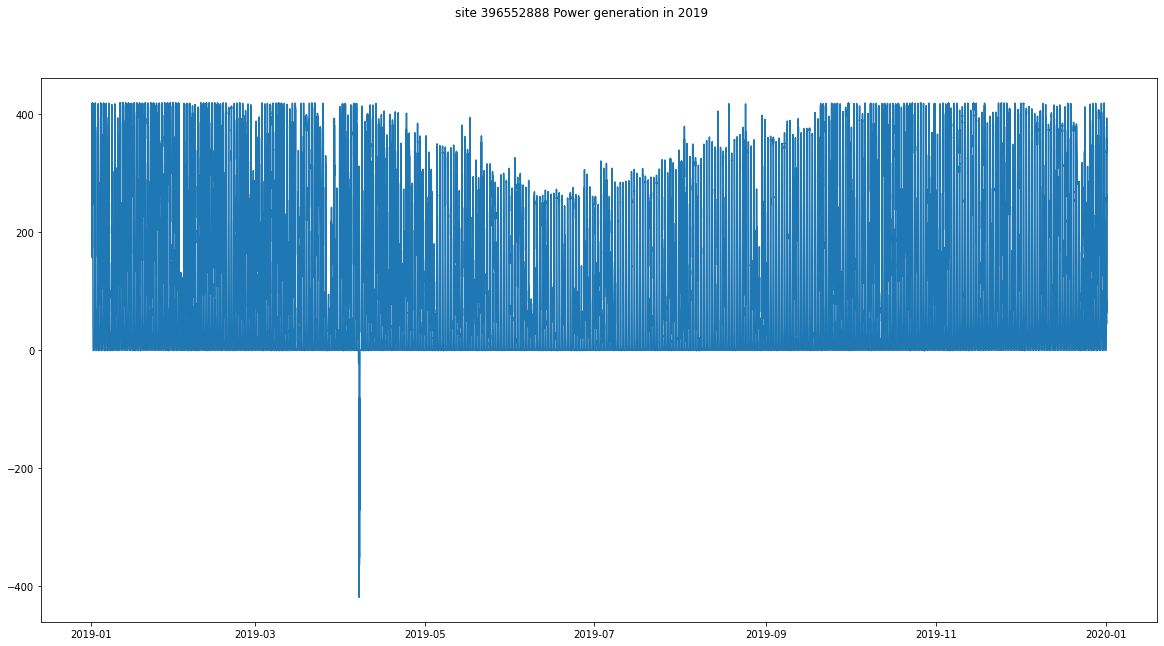

In [ ]:
fig, (ax1) = plt.subplots(1, sharex=True,figsize=(20,10))
fig.suptitle('site 396552888 Power generation in 2019')
ax1.plot(df_merged_brisbane_396552888[['local_timestamp']], df_merged_brisbane_396552888["energy_(Wh)"])

It can be seen that there are anomalies up to -400 wh so I decided to drop these observations.

In [ ]:
df_merged_brisbane_396552888.drop( df_merged_brisbane_396552888[ df_merged_brisbane_396552888["energy_(Wh)"] < -1 ].index , inplace=True)

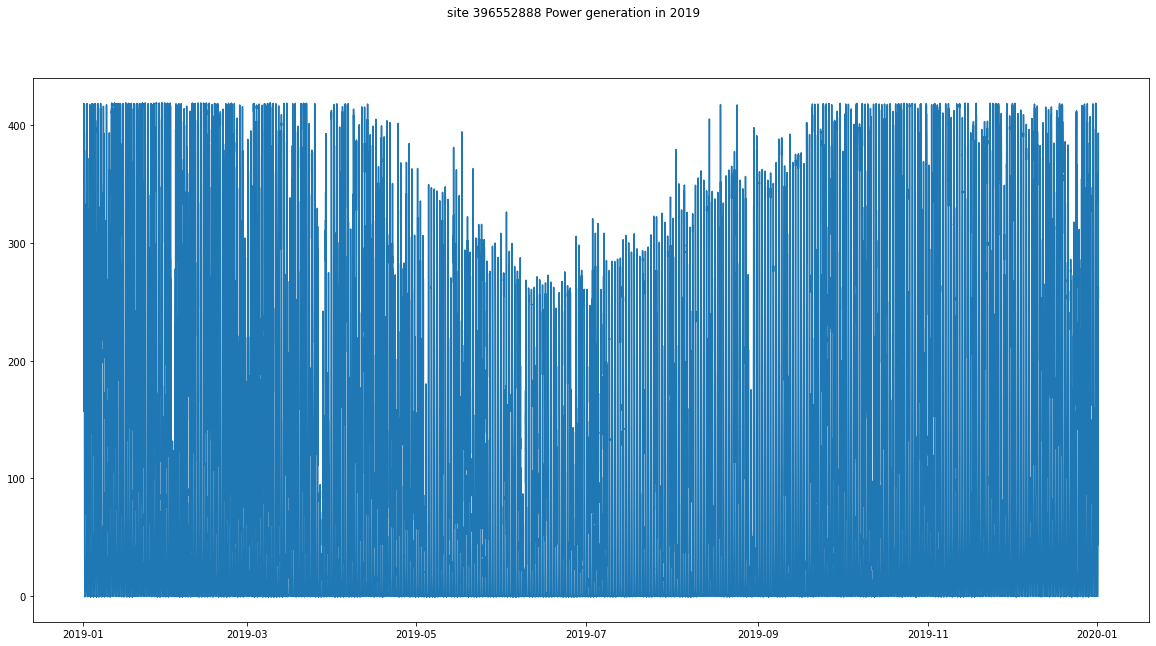

In [ ]:
fig, (ax1) = plt.subplots(1, sharex=True,figsize=(20,10))
fig.suptitle('site 396552888 Power generation in 2019')
ax1.plot(df_merged_brisbane_396552888[['local_timestamp']], df_merged_brisbane_396552888["energy_(Wh)"])

In [ ]:
df_merged_brisbane_396552888.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105308 entries, 0 to 105407
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   t_stamp_utc       105308 non-null  datetime64[ns, UTC]
 1   site_id           105308 non-null  int64              
 2   energy_(Wh)       105308 non-null  float64            
 3   voltage_max_(V)   105155 non-null  float64            
 4   voltage_min_(V)   105155 non-null  float64            
 5   postcode          105308 non-null  int64              
 6   state             105308 non-null  object             
 7   timezone_id       105308 non-null  object             
 8   local_timestamp   105308 non-null  datetime64[ns]     
 9   PeriodEnd         105308 non-null  datetime64[ns, UTC]
 10  PeriodStart       105308 non-null  object             
 11  Period            105308 non-null  object             
 12  AirTemp           105308 non-null  float64  

# Feature Selection

In this step, we will choose the weather variables from Backward stepwise regression as we did in the exploratory step.

In [ ]:
df_merged_brisbane_396552888 = df_merged_brisbane_396552888.dropna()
df_merged_brisbane_396552888_X = df_merged_brisbane_396552888[['voltage_max_(V)', 'voltage_min_(V)', 'AirTemp', 'CloudOpacity', 'Ghi','RelativeHumidity', 'WindSpeed10m']]
df_merged_brisbane_396552888_Y = df_merged_brisbane_396552888['energy_(Wh)']

x_train, x_test, y_train, y_test = train_test_split( 
        df_merged_brisbane_396552888_X, df_merged_brisbane_396552888_Y, test_size = 0.3, random_state = 0) 

lm = LinearRegression() 
lm.fit(x_train, y_train) 
pred = lm.predict(x_test) 

# add a column of ones as integer data type 
x = np.append(arr = np.ones([x_train.shape[0],1]).astype(int),  
              values = x_train, axis = 1) 
# choose a Significance level usually 0.05, if p>0.05 
#  for the highest values parameter, remove that value 
x_opt = x[:, [0, 1, 2, 3, 4, 5, 6, 7]] 
ols = sm.OLS(endog = y_train, exog = x_opt).fit() 
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            energy_(Wh)   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                 1.009e+05
Date:                Thu, 29 Oct 2020   Prob (F-statistic):               0.00
Time:                        15:31:19   Log-Likelihood:            -3.7256e+05
No. Observations:               73608   AIC:                         7.451e+05
Df Residuals:                   73600   BIC:                         7.452e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -532.4280     13.539    -39.326      0.000    -558.964    -505.892
x1             3.0639      0.146     21.031      0.000       2.778       3.349
x2            -0.7653      0.137     -5.566      0.000      -1.035      -0.496
x3            -0.5401      0.040    -13.506      0.000      -0.618      -0.462
x4             0.2620      0.008     34.635      0.000       0.247       0.277
x5             0.3624      0.001    377.834      0.000       0.360       0.364
x6             0.0337      0.009      3.587      0.000       0.015       0.052
x7             0.1312      0.102      1.287      0.198      -0.069       0.331
==============================================================================
Omnibus:                    12061.600   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           234191.118
Skew:                          -0.145   Prob(JB):                         0.00
Kurtosis:                      11.734   Cond. No.                     4.38e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.38e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
x_opt = x[:, [0, 1, 2, 3, 4, 5, 6]] 
ols = sm.OLS(endog = y_train, exog = x_opt).fit() 
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            energy_(Wh)   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                 1.177e+05
Date:                Thu, 29 Oct 2020   Prob (F-statistic):               0.00
Time:                        15:31:19   Log-Likelihood:            -3.7257e+05
No. Observations:               73608   AIC:                         7.451e+05
Df Residuals:                   73601   BIC:                         7.452e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -531.2732     13.509    -39.327      0.000    -557.751    -504.796
x1             3.0758      0.145     21.155      0.000       2.791       3.361
x2            -0.7803      0.137     -5.696      0.000      -1.049      -0.512
x3            -0.5353      0.040    -13.445      0.000      -0.613      -0.457
x4             0.2631      0.008     34.998      0.000       0.248       0.278
x5             0.3623      0.001    377.933      0.000       0.360       0.364
x6             0.0309      0.009      3.379      0.001       0.013       0.049
==============================================================================
Omnibus:                    12060.343   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           234417.657
Skew:                          -0.144   Prob(JB):                         0.00
Kurtosis:                      11.738   Cond. No.                     4.37e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
df_merged_brisbane_396552888_select_feature = df_merged_brisbane_396552888.set_index('local_timestamp')
df_merged_brisbane_396552888_select_feature = df_merged_brisbane_396552888.loc[:,['energy_(Wh)','voltage_max_(V)', 'voltage_min_(V)', 'AirTemp', 'CloudOpacity', 'Ghi','RelativeHumidity']]
df_merged_brisbane_396552888_select_feature.tail()

,energy_(Wh),voltage_max_(V),voltage_min_(V),AirTemp,CloudOpacity,Ghi,RelativeHumidity
105403,383.6394,244.2,241.3,26.7,0.0,914,59.1
105404,393.1939,244.4,239.8,26.8,0.0,926,58.5
105405,385.5344,242.3,238.1,26.9,0.0,938,57.9
105406,252.2833,241.9,236.4,27.0,0.0,949,57.3
105407,262.2086,243.6,238.1,27.1,0.0,960,56.7


There are 6 variables selected so we will take these to build a predictve model.

# Model Fitting with LSTM and Evaluation

At first, we have to convert the data record into a sequence which favors the LSTM algorithm.

In [ ]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = df_merged_brisbane_396552888_select_feature
values = dataset.values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 12, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

    var1(t-12)  var2(t-12)  var3(t-12)  ...  var5(t)   var6(t)   var7(t)
12    0.645157    0.573530    0.793987  ...      0.0  0.929134  0.473106
13    0.997800    0.676471    0.844098  ...      0.0  0.933508  0.469813
14    0.990520    0.702941    0.865256  ...      0.0  0.937883  0.465423
15    0.715536    0.685294    0.838530  ...      0.0  0.940507  0.461032
16    0.559728    0.682353    0.842984  ...      0.0  0.944007  0.457739

[5 rows x 85 columns]


t refers to one time step of 5 minutes. So t-12 means the one hour earlier observation. The var1 to var 6 refers to maximum voltage to RH, accordingly and the var7 means output power which the response variable. Next, we spit the data set into training and test set with 80% and 20% ratio by the training time which equal to 10 months. After that, the number of neurons is set to 50 ,the number of output neuron is 1, and the epoch is 20.

In [ ]:
# split into train and test sets
values = reframed.values
#n_train_hours = 365 * 24
n_train_hours = 86400
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(86400, 1, 84) (86400,) (18743, 1, 84) (18743,)


Epoch 1/20
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 2/20
1200/1200 [==============================] - 4s 3ms/step - loss: 6.6605e-04 - val_loss: 8.1044e-04
Epoch 3/20
1200/1200 [==============================] - 4s 3ms/step - loss: 6.4505e-04 - val_loss: 6.7645e-04
Epoch 4/20
1200/1200 [==============================] - 4s 3ms/step - loss: 5.4623e-04 - val_loss: 5.4870e-04
Epoch 5/20
1200/1200 [==============================] - 4s 3ms/step - loss: 4.7016e-04 - val_loss: 4.7069e-04
Epoch 6/20
1200/1200 [==============================] - 4s 3ms/step - loss: 4.1980e-04 - val_loss: 4.1758e-04
Epoch 7/20
1200/1200 [==============================] - 4s 3ms/step - loss: 3.7985e-04 - val_loss: 3.7748e-04
Epoch 8/20
1200/1200 [==============================] - 4s 3ms/step - loss: 3.4700e-04 - val_loss: 3.4534e-04
Epoch 9/20
1200/1200 [==============================] - 4s 3ms/step - loss: 3.1919e-04 - val_loss: 3.1812e-04
Epoch 10/20
1200/1

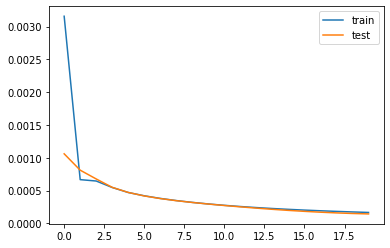

In [ ]:
from numpy import concatenate
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                27000     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 27,051
Trainable params: 27,051
Non-trainable params: 0
_________________________________________________________________


The performance metric is RMSE which can be calculated as below.

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 5.027


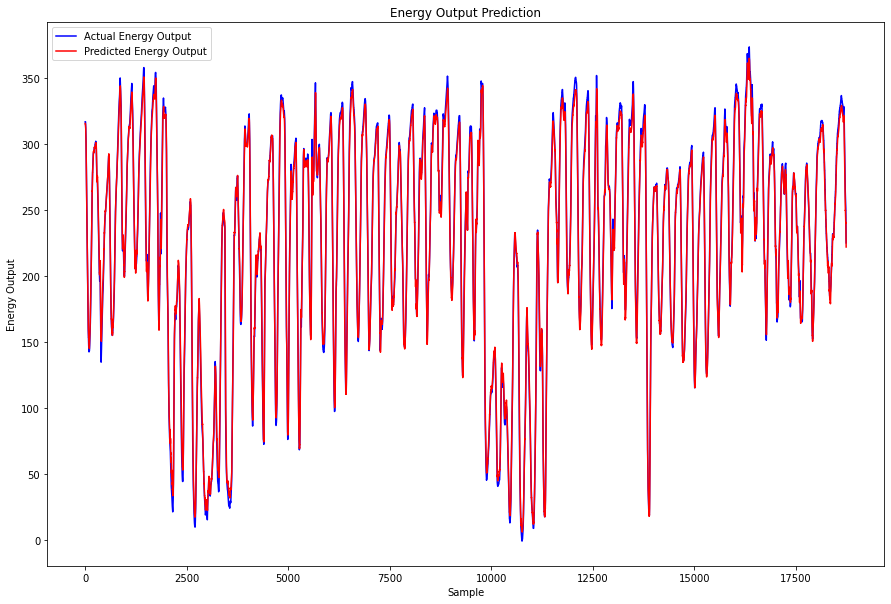

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(inv_y, color='blue', label='Actual Energy Output')
plt.plot(inv_yhat , color='red', label='Predicted Energy Output')
plt.title('Energy Output Prediction')
plt.xlabel('Sample')
plt.ylabel('Energy Output')
plt.legend()
plt.show()

The plot of actual values against the predicted values shows that the model is performing well.

Residual Error Analysis

To better understand the model and find the room for improvement, I perform residual error analysis on a histogram, Q-Q plot to check normality and the autocorrelation plot to visualise autocorrelation.

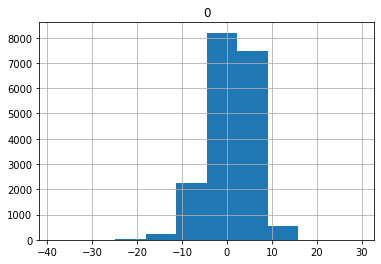

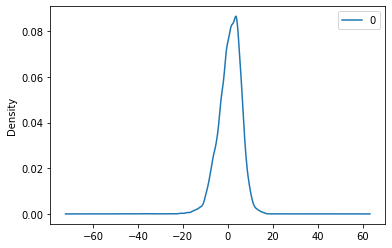

In [ ]:
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import autocorrelation_plot
# calculate residuals
residuals = [inv_y[i]-inv_yhat[i] for i in range(len(inv_yhat))]
residuals = DataFrame(residuals)
# histogram plot
residuals.hist()
plt.show()
residuals.plot(kind='kde')
plt.show()

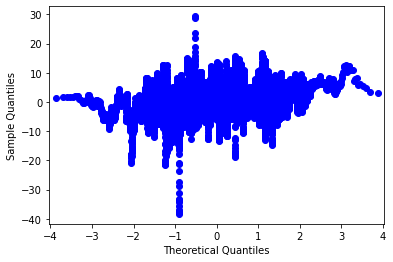

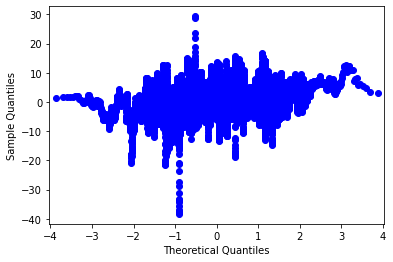

In [ ]:
residuals_array = np.array(residuals)
qqplot(residuals_array)

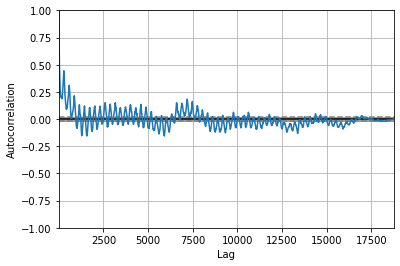

<Figure size 1080x720 with 0 Axes>

In [ ]:
autocorrelation_plot(residuals)
plt.figure(figsize=(15,10))
plt.show()

# Comparison with ARIMA model

Finally, I also want to compare the LSTM model with a more traditional time series forecasting model so I choose ARIMA based on the literature named A Comparison of ARIMA and LSTM in Forecasting Time Series.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
df_merged_brisbane_396552888_ARIMA = df_merged_brisbane_396552888.set_index('local_timestamp')
df_merged_brisbane_396552888_ARIMA = df_merged_brisbane_396552888_ARIMA.loc[:,'energy_(Wh)']
df_merged_brisbane_396552888_ARIMA.tail()

local_timestamp
2020-01-01 09:35:00    383.6394
2020-01-01 09:40:00    393.1939
2020-01-01 09:45:00    385.5344
2020-01-01 09:50:00    252.2833
2020-01-01 09:55:00    262.2086
Name: energy_(Wh), dtype: float64

In [ ]:
pip install pyramid.arima

     |████████████████████████████████| 604kB 6.0MB/s 


In [ ]:
from pyramid.arima import auto_arima
#divide into train and validation set
train = df_merged_brisbane_396552888_ARIMA[:int(0.7*(len(df_merged_brisbane_396552888_ARIMA)))]
valid = df_merged_brisbane_396552888_ARIMA[int(0.7*(len(df_merged_brisbane_396552888_ARIMA))):]
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.

/usr/local/lib/python3.6/dist-packages/pyramid/__init__.py:68: UserWarning:


    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https:/

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=703453.570, BIC=703508.809, Fit time=73.862 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=711554.081, BIC=711572.494, Fit time=1.733 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=709064.064, BIC=709091.684, Fit time=3.807 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=707342.084, BIC=707369.703, Fit time=5.933 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=704275.907, BIC=704321.939, Fit time=18.297 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=704233.418, BIC=704297.864, Fit time=21.156 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=704233.683, BIC=704279.715, Fit time=26.367 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=703299.883, BIC=703364.328, Fit time=118.857 seconds
Fit ARIMA: order=(3, 1, 4) seasonal_order=(0, 0, 0, 1); AIC=703299.647, BIC=703382.506, Fit time=97.475 se

In [ ]:
from sklearn.metrics import mean_squared_error

rms = sqrt(mean_squared_error(valid,forecast))
print(rms)

262.8610964176857


According to the RMSE, it is obvious that the LSTM model is superior than the ARIMA model. 